# Kaggle Competition - APTOS 2019 Blindness Detection
The solution to the Kaggle Challenge [APTOS 2019 Blindness Detection](https://www.kaggle.com/c/aptos2019-blindness-detection).
This notebook contains the code to solve the problem as well as several visualizations to display the data better. In this project machine learning algorithms from Scikit were used as well as Keras to solve the problem with a neural network.


In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import time
from tqdm import tqdm
from PIL import Image
import imgaug as ia
import imgaug.augmenters as iaa
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model, Sequential, Model
from keras.layers import Input, Dense, Flatten, Activation, Dropout, GlobalAveragePooling2D, BatchNormalization, Conv2D, MaxPooling2D, GaussianNoise
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, applications
from keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau
from keras import backend as K
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
# Parameters
run_local = True # for Kaggle Kernel set to False
path_prefix = '' if run_local else '../' 
use_pretrained = True
random_seed = 42

In [3]:
train_df = pd.read_csv(path_prefix+"input/aptos2019-blindness-detection/train.csv")
train_df["id_code"]=train_df["id_code"].apply(lambda x:x+".png")
train_df['diagnosis'] = train_df['diagnosis'].astype(str)
train_df.head()

,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


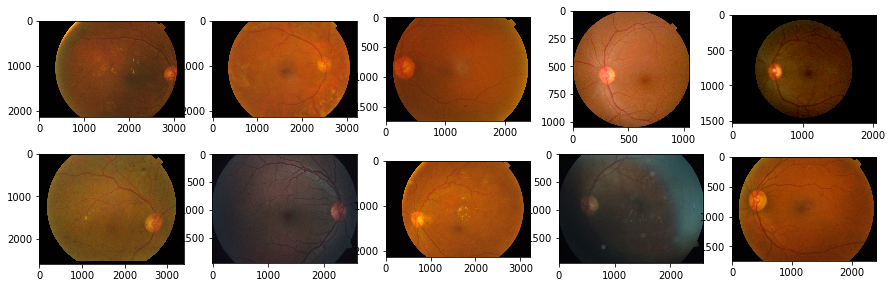

In [4]:
# Example of images 
img_names = train_df['id_code'][:10]

plt.figure(figsize=[15,15])
i = 1
for img_name in img_names:
    img = cv2.imread(path_prefix+"input/aptos2019-blindness-detection/train_images/%s" % img_name)[...,[2, 1, 0]]
    plt.subplot(6, 5, i)
    plt.imshow(img)
    i += 1
plt.show()

In [5]:
nb_classes = 5
lbls = list(map(str, range(nb_classes)))

nb_epochs = 100
img_size = 250
batch_size = 12 if run_local else 32

### Image Preprocessing

#### Preprocess

In [6]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

In [7]:
def preprocess_image(image):    
    image = np.array(image)
    image = cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0,0), img_size/10),-4, 128)        
    image = crop_image_from_gray(image)
    
    height, width, _ = image.shape
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    image = cv2.bitwise_and(image, image, mask=circle_img)
    image = crop_image_from_gray(image)
    image = cv2.resize(image,(img_size,img_size))

    return image

#### Show preprocessed images

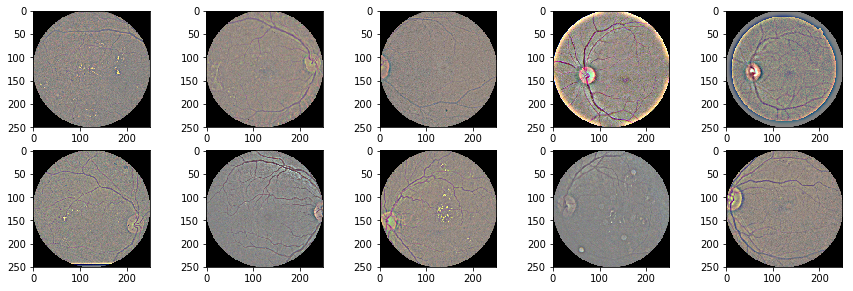

In [8]:
# Example of images 
img_names = train_df['id_code'][:10]

plt.figure(figsize=[15,15])
i = 1
for img_name in img_names:
    img = cv2.imread(path_prefix+"input/aptos2019-blindness-detection/train_images/%s" % img_name)[...,[2, 1, 0]]
    img = preprocess_image(img)
    plt.subplot(6, 5, i)
    plt.imshow(img)
    i += 1
plt.show()

#### Remove blurry image

In [9]:
def isClear(img, threshold = 60):
    return cv2.Laplacian(img, cv2.CV_64F).var() > threshold

In [10]:
#blur_list = []
#blur_list_id = []
#for i, image_id in enumerate(tqdm(train_df['id_code'])):
#    img = cv2.imread(path_prefix+"input/aptos2019-blindness-detection/train_images/%s" % image_id)
#    img = preprocess_image(img)
#    if(not isClear(img)):
#        blur_list.append(i)
#        blur_list_id.append(image_id)
#train_df = train_df.drop(blur_list)

### Image annotation

In [11]:
sometimes = lambda aug: iaa.Sometimes(0.5, aug)
sometimes2 = lambda aug: iaa.Sometimes(0.2, aug)
seq = iaa.Sequential(
        [
            # apply the following augmenters to most images
            iaa.Fliplr(0.5), # horizontally flip 50% of all images
            iaa.Flipud(0.2), # vertically flip 20% of all images
            sometimes(iaa.Affine(
                #scale={"x": (0.9, 1.1), "y": (0.9, 1.1)}, # scale images to 80-120% of their size, individually per axis
                #translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, # translate by -20 to +20 percent (per axis)                
                #rotate=(-10, 10), # rotate by -45 to +45 degrees
                shear=(-5, 5), # shear by -16 to +16 degrees
                order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
                cval=(0, 255), # if mode is constant, use a cval between 0 and 255
                mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
            )),
            sometimes2(iaa.Dropout(p=(0, 0.05))),
            sometimes2(iaa.Multiply((0.5, 1.5))),            
            sometimes2(iaa.ContrastNormalization((0.5, 1.0))),
            sometimes2(iaa.Sharpen(alpha=(0, 0.3), lightness=(0.7, 1.3))),
            sometimes2(iaa.Emboss(alpha=(0, 0.5), strength=(0, 0.5))) 
        ],
        random_order=True)

In [12]:
def load_augment_image(image_path, desired_size=img_size):
    im = Image.open(image_path).convert('RGB')
    np_array = np.array(im)    
    im = Image.fromarray(preprocess_image(np_array))    
    im = im.resize((desired_size, )*2, resample=Image.LANCZOS)
    np_im = np.array(im)    
    np_im = seq.augment_image(np_im)   
    return np_im

#### Show annotated images

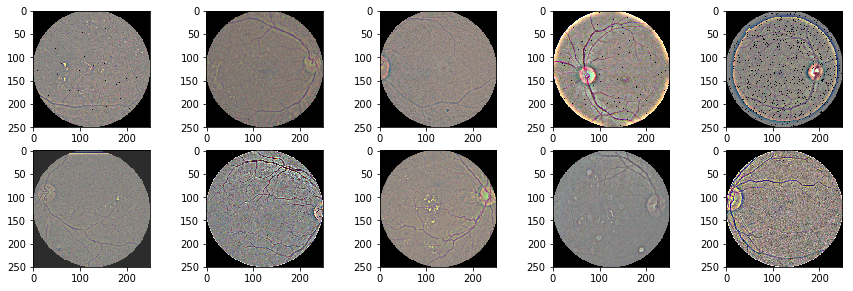

In [13]:
# Example of images 
img_names = train_df['id_code'][:10]

plt.figure(figsize=[15,15])
i = 1
for img_name in img_names:
    img = load_augment_image(path_prefix+"input/aptos2019-blindness-detection/train_images/%s" % img_name)
    plt.subplot(6, 5, i)
    plt.imshow(img)
    i += 1
plt.show()

### Load training and validation images

In [14]:
# Training Images
N = train_df.shape[0]
X = np.empty((N, img_size, img_size, 3), dtype=np.uint8)
for i, image_id in enumerate(tqdm(train_df['id_code'])):
    X[i, :, :, :] = load_augment_image(
        f'{path_prefix}input/aptos2019-blindness-detection/train_images/{image_id}'
    )
y = pd.get_dummies(train_df['diagnosis']).values 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3662/3662 [36:16<00:00,  1.50it/s]


### Split Training and Test

In [15]:
X_train, X_valid, y_train, y_valid  = train_test_split(X, y, test_size=0.20, random_state=random_seed)

### Mixup & Data Generator

In [16]:
class MixupGenerator():
    def __init__(self, X_train, y_train, batch_size=32, alpha=0.2, shuffle=True, datagen=None):
        self.X_train = X_train
        self.y_train = y_train
        self.batch_size = batch_size
        self.alpha = alpha
        self.shuffle = shuffle
        self.sample_num = len(X_train)
        self.datagen = datagen

    def __call__(self):
        while True:
            indexes = self.__get_exploration_order()
            itr_num = int(len(indexes) // (self.batch_size * 2))

            for i in range(itr_num):
                batch_ids = indexes[i * self.batch_size * 2:(i + 1) * self.batch_size * 2]
                X, y = self.__data_generation(batch_ids)

                yield X, y

    def __get_exploration_order(self):
        indexes = np.arange(self.sample_num)

        if self.shuffle:
            np.random.shuffle(indexes)

        return indexes

    def __data_generation(self, batch_ids):
        _, h, w, c = self.X_train.shape
        l = np.random.beta(self.alpha, self.alpha, self.batch_size)
        X_l = l.reshape(self.batch_size, 1, 1, 1)
        y_l = l.reshape(self.batch_size, 1)

        X1 = self.X_train[batch_ids[:self.batch_size]]
        X2 = self.X_train[batch_ids[self.batch_size:]]
        X = X1 * X_l + X2 * (1 - X_l)

        if self.datagen:
            for i in range(self.batch_size):
                X[i] = self.datagen.random_transform(X[i])
                X[i] = self.datagen.standardize(X[i])

        if isinstance(self.y_train, list):
            y = []

            for y_train_ in self.y_train:
                y1 = y_train_[batch_ids[:self.batch_size]]
                y2 = y_train_[batch_ids[self.batch_size:]]
                y.append(y1 * y_l + y2 * (1 - y_l))
        else:
            y1 = self.y_train[batch_ids[:self.batch_size]]
            y2 = self.y_train[batch_ids[self.batch_size:]]
            y = y1 * y_l + y2 * (1 - y_l)

        return X, y

In [17]:
def create_datagen():
    return ImageDataGenerator(
        zoom_range=0.15,
        fill_mode='constant',
        cval=0.,
        horizontal_flip=True,
        vertical_flip=True,
    )

data_generator = create_datagen().flow(X_train, y_train, batch_size=batch_size)
mixup_generator = MixupGenerator(X_train, y_train, batch_size=batch_size, alpha=0.2, datagen=create_datagen())()

### Distribution

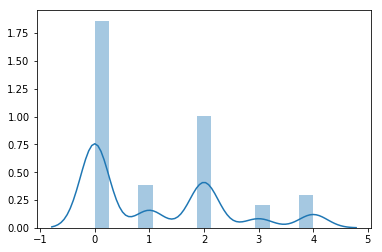

In [18]:
distribution = np.argmax(y_train,axis=1).astype('uint8')

sns.distplot(distribution);

#### Calc weights for unbalanced data

In [19]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(distribution),
                                                 distribution)

print('Class_weights: ' + str(class_weights))

Class_weights: [0.40288858 1.9397351  0.74529262 3.73121019 2.54695652]


### Load Pretrained Model

In [20]:
#model = applications.DenseNet121(weights=None,
#                            include_top=False,
#                            input_shape=(img_size, img_size, 3))
#if use_pretrained:
#    model.load_weights(path_prefix+'input/densenet-keras/DenseNet-BC-121-32-no-top.h5')    

#### Add custom Layers to model

In [21]:
#Adding custom layers 
#model_final = Sequential()
#model_final.add(model)
#model_final.add(GlobalAveragePooling2D())

#if use_pretrained:
#    model_final.add(Dropout(0.5))
#    model_final.add(Dense(2048, activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(l=0.1)))
#    model_final.add(BatchNormalization())
#    model_final.add(Activation("relu"))
#    model_final.add(Dropout(0.5))
#    model_final.add(Dense(1024, activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(l=0.1)))
#    model_final.add(BatchNormalization())
#    model_final.add(Activation("relu"))
#    model_final.add(Dropout(0.5))    
#    model_final.add(Dense(512, activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(l=0.1)))
#    model_final.add(BatchNormalization())
#    model_final.add(Activation("relu"))
#    model_final.add(Dropout(0.5))        
    
#model_final.add(Dense(nb_classes, activation="softmax"))

#print(model_final.summary())

#### Compile model

In [22]:
def build_model():
    model = Sequential([
        Conv2D(64, (3, 3), activation="relu", padding='same', input_shape=(img_size, img_size, 3)),
        BatchNormalization(),
        
        Conv2D(64, (3, 3), activation="relu", padding='same'),
        BatchNormalization(),
        
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.5),
        
        Conv2D(128, (3, 3), activation="relu", padding='same'),
        BatchNormalization(),
        
        Conv2D(128, (3, 3), activation="relu", padding='same'),
        BatchNormalization(),
        
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.5),
        
        Conv2D(256, (3, 3), activation="relu", padding='same'),
        BatchNormalization(),
        
        Conv2D(256, (3, 3), activation="relu", padding='same'),
        BatchNormalization(),
        
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.5),
        
        Conv2D(512, (3, 3), activation="relu", padding='same'),
        BatchNormalization(),
        
        Conv2D(512, (3, 3), activation="relu", padding='same'),
        BatchNormalization(),
        
        Conv2D(512, (3, 3), activation="relu", padding='same'),
        BatchNormalization(),
        
        Conv2D(512, (3, 3), activation="relu", padding='same'),
        BatchNormalization(),
        
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.5),
        
        Conv2D(512, (3, 3), activation="relu", padding='same'),
        BatchNormalization(),
        
        Conv2D(512, (3, 3), activation="relu", padding='same'),
        BatchNormalization(),
        
        GlobalAveragePooling2D(),
        Dropout(0.5),
        
        Dense(512, activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(l=0.1)),
        BatchNormalization(),
        Activation("relu"),
        Dropout(0.5),
        
        Dense(256, activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(l=0.1)),
        BatchNormalization(),
        Activation("relu"),
        Dropout(0.5),
        
        Dense(nb_classes, activation="softmax")
    ])
    return model

model_final = build_model()
print(model_final.summary())

Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 250, 250, 64)      1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 250, 250, 64)      256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 250, 250, 64)      36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 250, 250, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 125, 125, 64)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 125, 125, 64)      0         
_________________________________________________________________
con

In [23]:
#model_final.compile(optimizers.Adam(lr=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

#model_final.compile(optimizers.Nadam(lr=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

#model_final.compile(optimizers.Adadelta(),loss='categorical_crossentropy',metrics=['accuracy'])

#model_final.compile(optimizers.SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True),loss='categorical_crossentropy',metrics=['accuracy'])

#model_final.compile(optimizers.Adam(lr=0.00015),loss='categorical_crossentropy',metrics=['accuracy'])    

model_final.compile(optimizer = "adam", loss='categorical_crossentropy',metrics=['accuracy'])

#### Create Callbacks

In [ ]:
# Callbacks
now = time.strftime("%Y%m%d_%H%M%S")

#checkpoint = ModelCheckpoint("model.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
#early = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=25, mode='auto', restore_best_weights=True)
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='auto', cooldown=1, min_lr=0.0000001, verbose=1)
tensorboard = TensorBoard(log_dir='./logs/'+now, histogram_freq=0, write_graph=True, write_images=True)

checkpoint = ModelCheckpoint("model.h5",
                             monitor="val_acc",
                             mode="auto",
                             save_best_only = True,
                             save_weights_only = False,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 25,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 5,
                              verbose = 1,
                              min_delta = 0.00001)

callbacks = [earlystop, checkpoint, reduce_lr, tensorboard]

#### Start Training

In [ ]:
history = model_final.fit_generator(generator=mixup_generator,
                                    steps_per_epoch=X_train.shape[0]//batch_size,                                    
                                    validation_data=(X_valid, y_valid),                    
                                    validation_steps=X_valid.shape[0]//batch_size,                                    
                                    epochs=nb_epochs,
                                    #callbacks = [checkpoint, early, reduce_lr, tensorboard],
                                    callbacks=callbacks,
                                    class_weight=class_weights,
                                    max_queue_size=16,
                                    workers=1,
                                    use_multiprocessing=False,
                                    verbose=0)


Epoch 00001: val_acc improved from -inf to 0.47885, saving model to model.h5

Epoch 00002: val_acc improved from 0.47885 to 0.62074, saving model to model.h5

Epoch 00003: val_acc did not improve from 0.62074

Epoch 00004: val_acc did not improve from 0.62074

Epoch 00005: val_acc did not improve from 0.62074

Epoch 00006: val_acc did not improve from 0.62074

Epoch 00007: val_acc did not improve from 0.62074

Epoch 00008: val_acc did not improve from 0.62074

Epoch 00009: val_acc did not improve from 0.62074

Epoch 00010: val_acc did not improve from 0.62074

Epoch 00011: val_acc improved from 0.62074 to 0.67804, saving model to model.h5

Epoch 00012: val_acc did not improve from 0.67804

Epoch 00013: val_acc did not improve from 0.67804

Epoch 00014: val_acc did not improve from 0.67804

Epoch 00015: val_acc did not improve from 0.67804

Epoch 00016: val_acc did not improve from 0.67804

Epoch 00016: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 00017: v

### Plot training

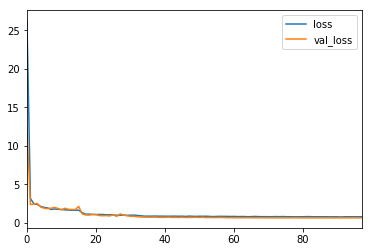

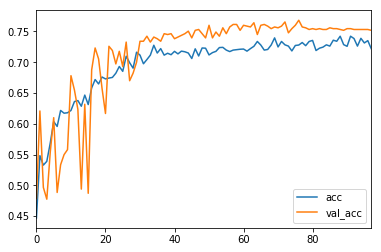

In [ ]:
with open('history.json', 'w') as f:
    json.dump(str(history.history), f)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot()

### Predict test Images

In [ ]:
test_df = pd.read_csv(path_prefix+'input/aptos2019-blindness-detection/test.csv')
test_df["id_code"]=test_df["id_code"].apply(lambda x:x+".png")
test_df.head()

,id_code
0,0005cfc8afb6.png
1,003f0afdcd15.png
2,006efc72b638.png
3,00836aaacf06.png
4,009245722fa4.png


In [ ]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_image)
test_generator = test_datagen.flow_from_dataframe(  
        dataframe=test_df,
        directory=path_prefix+"input/aptos2019-blindness-detection/test_images",    
        x_col="id_code",
        target_size=(img_size,img_size),
        batch_size=1,
        shuffle=False,
        color_mode='rgb',    
        class_mode=None,
        seed=random_seed
        )
test_generator.reset()

Found 1928 images.


#### Load model

In [ ]:
model = load_model('model.h5')

#### Predict

In [ ]:
predict = model_final.predict_generator(test_generator, steps = len(test_generator.filenames))

### Write Submission File

In [ ]:
filenames=test_generator.filenames
results=pd.DataFrame({"id_code":filenames,
                      "diagnosis":np.argmax(predict,axis=1)})
results['id_code'] = results['id_code'].map(lambda x: str(x)[:-4])
results.to_csv("submission.csv",index=False, columns=["id_code","diagnosis"])

### Plot 

In [ ]:
y_true = [0, 1, 2, 2, 2]
y_pred = [0, 0, 2, 2, 1]

#labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
#print(classification_report(y_true, y_pred, labels=labels))